# Confirming cleavage heterogeneity mechanisms *in silico*
## Cleavage site composition

**Purpose**: To systematically investigate the factors controlling site heterogeneity in targeted examples.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
from paper_utilities import cleavage

In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation/yeast"
CLVDIR  = os.path.join(PROJECT, 'saccharomyces_cerevisiae', 'analysis', 'motif_analysis', 'entropy_motif_conversion', '20240423-152708_epoch-29')
OUTDIR  = os.path.join(PROJECT, 'manuscript', 'analysis', 'cleavage_mechanisms')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [6]:
with open(os.path.join(RESOURCES, 'gold_data.cleavage_heterogeneity.ctr.pickle'), mode = 'rb') as handle:
    gold_tpdata = pickle.load(handle)

print(gold_tpdata.shape)


(11400, 457)


## ANALYSIS

## Mechanism 1: Hexamer elements around cleavage site

### Adding U-rich elements around high entropy sites

In [7]:
## Load data from cleavage site randomization

hi_data = pd.read_csv(os.path.join(CLVDIR, 'surrounding_cleavage_additions.high_entropy.txt'), 
                   sep = "\t", names = ['testID','index','iteration','category','sequence','count','indices','absolutePosition','relativePosition','testMotif','cleavageVector'])

print(hi_data.shape)


## Process string vectors into numeric numpy arrays

hi_data['indices']         = hi_data['indices'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")] if (x != "[]") else np.asarray([])))
hi_data['cleavageVector']  = hi_data['cleavageVector'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")]))
hi_data['cleavageEntropy'] = hi_data['cleavageVector'].apply(lambda x : cleavage.calculate_entropy_from_vector(x))


## Identify original and replaced cleavage sites

original_hi_data = hi_data.loc[hi_data['category'] == 'Original'].copy()
converted_hi_data = hi_data.loc[hi_data['category'] == 'Added'].copy()

print(original_hi_data.shape)
print(converted_hi_data.shape)


## Match the number of U- and UA/UA-rich motifs in the region of interest

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['consensus_entropy']))
converted_hi_data['consensusEntropy'] = converted_hi_data['testID'].apply(lambda x : mdict[x])

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['count_U_d2_-15_15']))
converted_hi_data['originalCountU'] = converted_hi_data['testID'].apply(lambda x : mdict[x])

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['count_UA_d2_-15_0']))
converted_hi_data['originalCountUAup'] = converted_hi_data['testID'].apply(lambda x : mdict[x])

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['count_UA_d2_0_15']))
converted_hi_data['originalCountUAdn'] = converted_hi_data['testID'].apply(lambda x : mdict[x])


## Calculate the change in entropy after motif conversion

edict = dict(zip(original_hi_data['testID'], original_hi_data['cleavageEntropy']))

converted_hi_data['originalEntropy'] = converted_hi_data['testID'].apply(lambda x: edict[x])
converted_hi_data['fcEntropy']       = converted_hi_data.apply(lambda row: row['cleavageEntropy'] / row['originalEntropy'], axis = 1)
converted_hi_data['deltaEntropy']    = converted_hi_data.apply(lambda row: row['cleavageEntropy'] - row['originalEntropy'], axis = 1)

print(converted_hi_data['consensusEntropy'].value_counts())
print(converted_hi_data['deltaEntropy'].describe())


(60238, 11)
(182, 12)
(60056, 12)
True    60056
Name: consensusEntropy, dtype: int64
count    60056.000000
mean        -0.416422
std          0.335644
min         -2.101317
25%         -0.615208
50%         -0.366552
75%         -0.161127
max          0.426343
Name: deltaEntropy, dtype: float64


In [8]:
all_four = {}

for i,row in converted_hi_data.loc[converted_hi_data['count'] == 4, ['testID','iteration']].drop_duplicates().iterrows():
    
    if (row['testID'] not in all_four):
        all_four[row['testID']] = {}
        
    all_four[row['testID']][row['iteration']] = 1

print(len(list(all_four.keys())))
print(sum(len(v) for v in all_four.values()))

converted_hi_data['allFour'] = converted_hi_data.apply(lambda row : all_four.get(row['testID'],{}).get(row['iteration'],0), axis=1).astype(bool)
print(converted_hi_data['allFour'].value_counts())


182
7264
False    31000
True     29056
Name: allFour, dtype: int64


In [9]:
cond0 = (converted_hi_data['consensusEntropy'] == True)
cond1 = (converted_hi_data['count'].between(1,4))
cond2 = (converted_hi_data['originalCountU'] == 0)
cond3 = (converted_hi_data['originalCountUAup'] >= 1)
cond4 = (converted_hi_data['originalCountUAdn'] >= 1)
cond5 = (converted_hi_data['allFour'] == True)

condPLOT = (cond0 & cond1 & cond2 & cond3 & cond4 & cond5)
print(cond0.sum(), cond1.sum(), cond2.sum(), cond3.sum(), cond4.sum(), cond5.sum(), condPLOT.sum())

plot_data = converted_hi_data.loc[condPLOT].copy()
plot_data['testLabel'] = plot_data['testID'] + ':' + plot_data['iteration'].astype(str)
print(plot_data['testID'].nunique(), plot_data[['testID','index']].drop_duplicates().shape)

wide_data = pd.pivot(plot_data, index = 'testLabel', columns = 'count', values = 'deltaEntropy')
wide_data.columns = wide_data.columns.map(str)
print(wide_data.shape, wide_data.isna().any(axis = 1).sum())


60056 60056 60056 60056 60056 29056 29056
182 (182, 2)
(7264, 4) 0


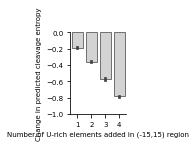


Corresponding statistics-
	Wilcoxon signed-rank paired test (group 1 vs 2):  3034874.000 0.00E+00
	Wilcoxon signed-rank paired test (group 1 vs 3):   821817.000 0.00E+00
	Wilcoxon signed-rank paired test (group 1 vs 4):   217936.000 0.00E+00

Summary data-
       count    median      mean       std       min       max
count                                                         
1       7264 -0.153720 -0.189769  0.204098 -1.281465  0.401030
2       7264 -0.334512 -0.362486  0.263737 -1.668834  0.397024
3       7264 -0.554251 -0.573852  0.315642 -1.820752  0.397952
4       7264 -0.756980 -0.784913  0.359011 -2.101317  0.293698


In [10]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

x = 'count'
y = 'deltaEntropy'

sns.barplot(data = plot_data, x = x, y = y,
            color = 'lightgray', edgecolor = 'black', linewidth = 0.5,
            ax = ax)

ax.set_xlabel("Number of U-rich elements added in (-15,15) region")

ax.set_ylabel("Change in predicted cleavage entropy")
ax.set_ylim(-1,0)
ax.yaxis.set_major_locator(MultipleLocator(0.2))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.high_entropy.barplot.{y}_by_{x}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nCorresponding statistics-")

for c in wide_data.columns:

    if (c == '1'):
        continue
        
    stat, pval = st.wilcoxon(wide_data[c], wide_data['1'])
    print(f"\tWilcoxon signed-rank paired test (group 1 vs {c}): {stat:12.03f} {pval:8.02E}")

print("\nSummary data-")
print(plot_data.groupby(x)[y].agg(['count','median','mean','std','min','max']))


### Individual examples

#### Example 1

In [12]:
rs = 3945466334; example_id = "006467:III:197520:-"; example_iter = 22

example_gene    = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'gene'].iloc[0]
example_obsent  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'observed_entropy'].iloc[0]
example_maxclv  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'ctr_cleavage'].iloc[0]
example_readvec = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'readvec'].iloc[0]
print(f"Gene={example_gene}, observed_entropy={example_obsent}")

example_bin0 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == 0) & (hi_data['count'] ==  0)].sample(1, random_state = rs).iloc[0]
example_bin1 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 1)].sample(1, random_state = rs).iloc[0]
example_bin2 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 2)].sample(1, random_state = rs).iloc[0]
example_bin3 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 3)].sample(1, random_state = rs).iloc[0]
example_bin4 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 4)].sample(1, random_state = rs).iloc[0]

example_bin_max = max([max(x['cleavageVector']) for x in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]])
print(f"Max normalized cleavage prediction: {example_bin_max}")

for e in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]:
    print(e.name, e['sequence'][int(example_maxclv-20):int(example_maxclv+20)], e['cleavageEntropy'], e['count'], sorted(e['indices'].tolist()))


Gene=YCR038C, observed_entropy=2.907497376763022
Max normalized cleavage prediction: 0.27015799283981323
34394 GAAAATTAAGAATACTTGCATAACTACAGTAGATAATATT 2.985718620587767 0 []
34468 GAAAATTAAGAATTCTTTCATAACTACAGTAGATAATATT 2.9220679047032405 1 [-8.0]
34469 GAAAATTAAGAATTCTTTCATATTTTTTGTAGATAATATT 2.610943771939796 2 [-8.0, 2.0]
34470 GAAAATTCTTTTTTCTTTCATATTTTTTGTAGATAATATT 2.4863798673575968 3 [-14.0, -8.0, 2.0]
34471 GAAAATTCTTTTTTCTTTCATATTTTTTGTTTTTTATATT 1.9403478129043485 4 [-14.0, -8.0, 2.0, 9.0]


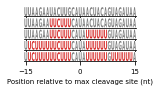

In [13]:
fig,axes = plt.subplots(5,1, figsize = (2,1), sharex = True, sharey = True)

xs = np.arange(-15,16,1)

for ax,ex in zip(axes,[example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]):
    
    ## plot sequence logo
    exseq = ex['sequence'][int(example_maxclv-15):int(example_maxclv+16)]
    encoding = cleavage.encode_sequence(exseq)
    seqmotif = pd.DataFrame(encoding, columns = ['A','C','G','U'], index = xs)

    logo = logomaker.Logo(seqmotif, ax = ax, width = 0.8, vpad = 0.05, color_scheme = {'A':'gray', 'U':'gray', 'G':'gray', 'C':'gray'})
    
    for i in ex['indices']:
        for j in np.arange(i,i+6,1):
            logo.style_single_glyph(int(j), exseq[int(j+15)].replace("T","U"), color = "#d62a28")

    ax.set_xticks(np.arange(-15,16,15))
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
axes[-1].set_xlabel("Position relative to max cleavage site (nt)")

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.high_entropy.{example_id.replace(":","_")}.example_sequence.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


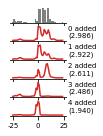

In [14]:
fig,axes = plt.subplots(6,1, figsize = (1,2), sharex = True, sharey = False)

for i,(ax,ex) in enumerate(zip(axes, [example_readvec, example_bin0, example_bin1, example_bin2, example_bin3, example_bin4])):
    
    if (i == 0):
        ax.bar(np.arange(0,50,1), ex, width = 1, color = 'gray')
    else:
        ax.plot(ex['cleavageVector'], color = '#d62a28')
        ax.text(x=1.05, y=1, s=f"{ex['count']} added\n({ex['cleavageEntropy']:.03f})", transform = ax.transAxes, ha = 'left', va = 'top')

    ax.set_xticks(np.arange(0,51,25))
    ax.set_xticklabels(np.arange(-25,26,25))
    
    ax.set_yticks([])
#     ax.set_ylim(0,example_bin_max*1.1)

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.high_entropy.{example_id.replace(":","_")}.example_cleavage.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Example 2

In [15]:
rs = 1865467865; example_id = "001303:IX:48052:+"; example_iter = 11

example_gene    = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'gene'].iloc[0]
example_obsent  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'observed_entropy'].iloc[0]
example_maxclv  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'ctr_cleavage'].iloc[0]
example_readvec = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'readvec'].iloc[0]
print(f"Gene={example_gene}, observed_entropy={example_obsent}")

example_bin0 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == 0) & (hi_data['count'] ==  0)].sample(1, random_state = rs).iloc[0]
example_bin1 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 1)].sample(1, random_state = rs).iloc[0]
example_bin2 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 2)].sample(1, random_state = rs).iloc[0]
example_bin3 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 3)].sample(1, random_state = rs).iloc[0]
example_bin4 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 4)].sample(1, random_state = rs).iloc[0]

example_bin_max = max([max(x['cleavageVector']) for x in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]])
print(f"Max normalized cleavage prediction: {example_bin_max}")

for e in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]:
    print(e.name, e['sequence'][int(example_maxclv-20):int(example_maxclv+20)], e['cleavageEntropy'], e['count'], sorted(e['indices'].tolist()))


Gene=YIL156W-B, observed_entropy=3.1286451276389964
Max normalized cleavage prediction: 0.32465699315071106
5971 CAAAATTAATAACCGCAACTTAAAGAGCTATCGCTATCGA 3.4163589998569703 0 []
6004 CAAAATTAATAATTTTTTCTTAAAGAGCTATCGCTATCGA 3.3278319510096264 1 [-8.0]
6005 CAAAATTAATAATTTTTTCTTATTTCTTTATCGCTATCGA 2.8294372535341576 2 [-8.0, 2.0]
6006 CAAAATTAATAATTTTTTCTTATTTCTTTTTTTTTATCGA 2.710540005796679 3 [-8.0, 2.0, 8.0]
6007 CAAAATTTCTTATTTTTTCTTATTTCTTTTTTTTTATCGA 2.3171265957955525 4 [-15.0, -8.0, 2.0, 8.0]


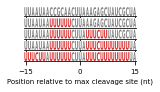

In [16]:
fig,axes = plt.subplots(5,1, figsize = (2,1), sharex = True, sharey = True)

xs = np.arange(-15,16,1)

for ax,ex in zip(axes,[example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]):
    
    ## plot sequence logo
    exseq = ex['sequence'][int(example_maxclv-15):int(example_maxclv+16)]
    encoding = cleavage.encode_sequence(exseq)
    seqmotif = pd.DataFrame(encoding, columns = ['A','C','G','U'], index = xs)

    logo = logomaker.Logo(seqmotif, ax = ax, width = 0.8, vpad = 0.05, color_scheme = {'A':'gray', 'U':'gray', 'G':'gray', 'C':'gray'})
    
    for i in ex['indices']:
        for j in np.arange(i,i+6,1):
            logo.style_single_glyph(int(j), exseq[int(j+15)].replace("T","U"), color = "#d62a28")

    ax.set_xticks(np.arange(-15,16,15))
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
axes[-1].set_xlabel("Position relative to max cleavage site (nt)")

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.high_entropy.{example_id.replace(":","_")}.example_sequence.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


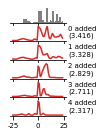

In [17]:
fig,axes = plt.subplots(6,1, figsize = (1,2), sharex = True, sharey = False)

for i,(ax,ex) in enumerate(zip(axes, [example_readvec, example_bin0, example_bin1, example_bin2, example_bin3, example_bin4])):
    
    if (i == 0):
        ax.bar(np.arange(0,50,1), ex, width = 1, color = 'gray')
    else:
        ax.plot(ex['cleavageVector'], color = '#d62a28')
        ax.text(x=1.05, y=1, s=f"{ex['count']} added\n({ex['cleavageEntropy']:.03f})", transform = ax.transAxes, ha = 'left', va = 'top')

    ax.set_xticks(np.arange(0,51,25))
    ax.set_xticklabels(np.arange(-25,26,25))
    
    ax.set_yticks([])
#     ax.set_ylim(0,example_bin_max*1.1)

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.high_entropy.{example_id.replace(":","_")}.example_cleavage.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Example 3

In [18]:
rs = 894727845; example_id = "010105:XIII:426299:-"; example_iter = 62

example_gene    = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'gene'].iloc[0]
example_obsent  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'observed_entropy'].iloc[0]
example_maxclv  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'ctr_cleavage'].iloc[0]
example_readvec = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'readvec'].iloc[0]
print(f"Gene={example_gene}, observed_entropy={example_obsent}")

example_bin0 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == 0) & (hi_data['count'] ==  0)].sample(1, random_state = rs).iloc[0]
example_bin1 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 1)].sample(1, random_state = rs).iloc[0]
example_bin2 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 2)].sample(1, random_state = rs).iloc[0]
example_bin3 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 3)].sample(1, random_state = rs).iloc[0]
example_bin4 = hi_data.loc[(hi_data['testID'] == example_id) & (hi_data['iteration'] == example_iter) & (hi_data['count'] == 4)].sample(1, random_state = rs).iloc[0]

example_bin_max = max([max(x['cleavageVector']) for x in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]])
print(f"Max normalized cleavage prediction: {example_bin_max}")

for e in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]:
    print(e.name, e['sequence'][int(example_maxclv-20):int(example_maxclv+20)], e['cleavageEntropy'], e['count'], sorted(e['indices'].tolist()))


Gene=YMR080C, observed_entropy=3.249391074294353
Max normalized cleavage prediction: 0.3778040111064911
50945 AAAATAAACTAAAATCAAGGTATGGCTGTAGAAAATGATA 3.587324984746771 0 []
51146 AAAATAAACTAAAATTTTTTTATGGCTGTAGAAAATGATA 3.314770736694117 1 [-6.0]
51147 AAAATAAACTAAAATTTTTTTATTTCTTTAGAAAATGATA 3.0853531302918125 2 [-6.0, 2.0]
51148 AAAATAAATTTTCTTTTTTTTATTTCTTTAGAAAATGATA 2.480678586961029 3 [-12.0, -6.0, 2.0]
51149 AAAATAAATTTTCTTTTTTTTATTTCTTTTTTTTATGATA 1.9738881667843025 4 [-12.0, -6.0, 2.0, 8.0]


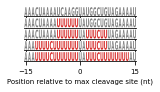

In [19]:
fig,axes = plt.subplots(5,1, figsize = (2,1), sharex = True, sharey = True)

xs = np.arange(-15,16,1)

for ax,ex in zip(axes,[example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]):
    
    ## plot sequence logo
    exseq = ex['sequence'][int(example_maxclv-15):int(example_maxclv+16)]
    encoding = cleavage.encode_sequence(exseq)
    seqmotif = pd.DataFrame(encoding, columns = ['A','C','G','U'], index = xs)

    logo = logomaker.Logo(seqmotif, ax = ax, width = 0.8, vpad = 0.05, color_scheme = {'A':'gray', 'U':'gray', 'G':'gray', 'C':'gray'})
    
    for i in ex['indices']:
        for j in np.arange(i,i+6,1):
            logo.style_single_glyph(int(j), exseq[int(j+15)].replace("T","U"), color = "#d62a28")

    ax.set_xticks(np.arange(-15,16,15))
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
axes[-1].set_xlabel("Position relative to max cleavage site (nt)")

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.high_entropy.{example_id.replace(":","_")}.example_sequence.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


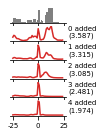

In [20]:
fig,axes = plt.subplots(6,1, figsize = (1,2), sharex = True, sharey = False)

for i,(ax,ex) in enumerate(zip(axes, [example_readvec, example_bin0, example_bin1, example_bin2, example_bin3, example_bin4])):
    
    if (i == 0):
        ax.bar(np.arange(0,50,1), ex, width = 1, color = 'gray')
    else:
        ax.plot(ex['cleavageVector'], color = '#d62a28')
        ax.text(x=1.05, y=1, s=f"{ex['count']} added\n({ex['cleavageEntropy']:.03f})", transform = ax.transAxes, ha = 'left', va = 'top')

    ax.set_xticks(np.arange(0,51,25))
    ax.set_xticklabels(np.arange(-25,26,25))
    
    ax.set_yticks([])
#     ax.set_ylim(0,example_bin_max*1.1)

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.high_entropy.{example_id.replace(":","_")}.example_cleavage.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


### Adding UA/UA-rich elements around low entropy sites

In [21]:
## Load data from cleavage site randomization

lo_data = pd.read_csv(os.path.join(CLVDIR, 'surrounding_cleavage_additions.low_entropy.txt'), 
                   sep = "\t", names = ['testID','index','iteration','category','sequence','count','indices','absolutePosition','relativePosition','testMotif','cleavageVector'])

print(lo_data.shape)


## Process string vectors into numeric numpy arrays

lo_data['indices']         = lo_data['indices'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")] if (x != "[]") else np.asarray([])))
lo_data['cleavageVector']  = lo_data['cleavageVector'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")]))
lo_data['cleavageEntropy'] = lo_data['cleavageVector'].apply(lambda x : cleavage.calculate_entropy_from_vector(x))


## Identify original and replaced cleavage sites

original_lo_data = lo_data.loc[lo_data['category'] == 'Original'].copy()
converted_lo_data = lo_data.loc[lo_data['category'] == 'Added'].copy()

print(original_lo_data.shape)
print(converted_lo_data.shape)


## Match the number of U- and UA/UA-rich motifs in the region of interest

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['consensus_entropy']))
converted_lo_data['consensusEntropy'] = converted_lo_data['testID'].apply(lambda x : mdict[x])

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['count_U_d2_-15_0']))
converted_lo_data['originalCountUup'] = converted_lo_data['testID'].apply(lambda x : mdict[x])

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['count_U_d2_0_15']))
converted_lo_data['originalCountUdn'] = converted_lo_data['testID'].apply(lambda x : mdict[x])

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['count_UA_d2_-15_0']))
converted_lo_data['originalCountUAup'] = converted_lo_data['testID'].apply(lambda x : mdict[x])

mdict = dict(zip(gold_tpdata['label'], gold_tpdata['count_UA_d2_0_15']))
converted_lo_data['originalCountUAdn'] = converted_lo_data['testID'].apply(lambda x : mdict[x])


## Calculate the change in entropy after motif conversion

edict = dict(zip(original_lo_data['testID'], original_lo_data['cleavageEntropy']))

converted_lo_data['originalEntropy'] = converted_lo_data['testID'].apply(lambda x: edict[x])
converted_lo_data['fcEntropy']       = converted_lo_data.apply(lambda row: row['cleavageEntropy'] / row['originalEntropy'], axis = 1)
converted_lo_data['deltaEntropy']    = converted_lo_data.apply(lambda row: row['cleavageEntropy'] - row['originalEntropy'], axis = 1)

print(converted_lo_data['consensusEntropy'].value_counts())
print(converted_lo_data['deltaEntropy'].describe())


(73319, 11)
(222, 12)
(73097, 12)
True    73097
Name: consensusEntropy, dtype: int64
count    73097.000000
mean         0.720243
std          0.394212
min         -0.860705
25%          0.441675
50%          0.727743
75%          1.000426
max          2.119908
Name: deltaEntropy, dtype: float64


In [22]:
all_four = {}

for i,row in converted_lo_data.loc[converted_lo_data['count'] == 4, ['testID','iteration']].drop_duplicates().iterrows():
    
    if (row['testID'] not in all_four):
        all_four[row['testID']] = {}
        
    all_four[row['testID']][row['iteration']] = 1

print(len(list(all_four.keys())))
print(sum(len(v) for v in all_four.values()))

converted_lo_data['allFour'] = converted_lo_data.apply(lambda row : all_four.get(row['testID'],{}).get(row['iteration'],0), axis=1).astype(bool)
print(converted_lo_data['allFour'].value_counts())


222
8753
False    38085
True     35012
Name: allFour, dtype: int64


In [23]:
cond0 = (converted_lo_data['consensusEntropy'] == True)
cond1 = converted_lo_data['count'].between(1,4)
cond2 = (converted_lo_data['originalCountUup'] >= 1)
cond3 = (converted_lo_data['originalCountUdn'] >= 1)
cond4 = (converted_lo_data['originalCountUAup'] == 0)
cond5 = (converted_lo_data['originalCountUAdn'] == 0)
cond6 = (converted_lo_data['allFour'] == True)

condPLOT = (cond0 & cond1 & cond2 & cond3 & cond4 & cond5 & cond6)
print(cond0.sum(), cond1.sum(), cond2.sum(), cond3.sum(), cond4.sum(), cond5.sum(), cond6.sum(), condPLOT.sum())

plot_data = converted_lo_data.loc[condPLOT].copy()
plot_data['testLabel'] = plot_data['testID'] + ':' + plot_data['iteration'].astype(str)
print(plot_data['testID'].nunique(), plot_data[['testID','index']].drop_duplicates().shape)

wide_data = pd.pivot(plot_data, index = 'testLabel', columns = 'count', values = 'deltaEntropy')
wide_data.columns = wide_data.columns.map(str)
print(wide_data.shape, wide_data.isna().any(axis = 1).sum())


73097 73097 73097 73097 73097 73097 35012 35012
222 (222, 2)
(8753, 4) 0


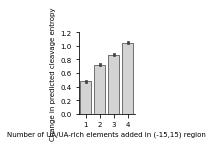


Corresponding statistics-
	Wilcoxon signed-rank paired test (group 1 vs 2):  5008009.000 0.00E+00
	Wilcoxon signed-rank paired test (group 1 vs 3):  2728242.000 0.00E+00
	Wilcoxon signed-rank paired test (group 1 vs 4):   716013.000 0.00E+00

Summary data-
       count    median      mean       std       min       max
count                                                         
1       8753  0.466781  0.478464  0.326873 -0.784690  1.686157
2       8753  0.738808  0.720106  0.355357 -0.709585  1.916462
3       8753  0.893083  0.869060  0.360519 -0.860705  2.119908
4       8753  1.058626  1.043378  0.337096 -0.654265  2.083443


In [24]:
fig,ax = plt.subplots(1,1, figsize = (1,1.5))

x = 'count'
y = 'deltaEntropy'

sns.barplot(data = plot_data, x = x, y = y,
            color = 'lightgray', edgecolor = 'black', linewidth = 0.5,
            ax = ax)

ax.set_xlabel("Number of UA/UA-rich elements added in (-15,15) region")

ax.set_ylabel("Change in predicted cleavage entropy")
ax.set_ylim(0,1.2)
ax.yaxis.set_major_locator(MultipleLocator(0.2))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.low_entropy.barplot.{y}_by_{x}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("\nCorresponding statistics-")

for c in wide_data.columns:

    if (c == '1'):
        continue
    
    stat, pval = st.wilcoxon(wide_data[c], wide_data['1'])
    print(f"\tWilcoxon signed-rank paired test (group 1 vs {c}): {stat:12.03f} {pval:8.02E}")

print("\nSummary data-")
print(plot_data.groupby(x)[y].agg(['count','median','mean','std','min','max']))


### Individual examples

#### Example 1

In [26]:
rs = 2660129116; example_id = "004615:XIV:352704:+"; example_iter = 61
            
example_gene    = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'gene'].iloc[0]
example_obsent  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'observed_entropy'].iloc[0]
example_maxclv  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'ctr_cleavage'].iloc[0]
example_readvec = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'readvec'].iloc[0]
print(f"Gene={example_gene}, observed_entropy={example_obsent}")

example_bin0 = lo_data.loc[(lo_data['testID'] == example_id) & (lo_data['iteration'] == 0) & (lo_data['count'] ==  0)].sample(1, random_state = rs).iloc[0]
example_bin1 = lo_data.loc[(lo_data['testID'] == example_id) & (lo_data['iteration'] == example_iter) & (lo_data['count'] == 1)].sample(1, random_state = rs).iloc[0]
example_bin2 = lo_data.loc[(lo_data['testID'] == example_id) & (lo_data['iteration'] == example_iter) & (lo_data['count'] == 2)].sample(1, random_state = rs).iloc[0]
example_bin3 = lo_data.loc[(lo_data['testID'] == example_id) & (lo_data['iteration'] == example_iter) & (lo_data['count'] == 3)].sample(1, random_state = rs).iloc[0]
example_bin4 = lo_data.loc[(lo_data['testID'] == example_id) & (lo_data['iteration'] == example_iter) & (lo_data['count'] == 4)].sample(1, random_state = rs).iloc[0]

example_bin_max = max([max(x['cleavageVector']) for x in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]])
print(f"Max normalized cleavage prediction: {example_bin_max}")

for e in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]:
    print(e.name, e['sequence'][int(example_maxclv-20):int(example_maxclv+20)], e['cleavageEntropy'], e['count'], sorted(e['indices'].tolist()))


Gene=YNL146W, observed_entropy=1.3168158215347037
Max normalized cleavage prediction: 0.5602419972419739
26356 ACAGATTTTTTCATGTTTTTCTTTTCTGATACGCCTTTCC 1.9450637002516502 0 []
26552 ACAGATTTTTTCATGTTTTTCTTAAAATATACGCCTTTCC 2.362521284029478 1 [3.0]
26553 ACAGATTTTTTCAAATAATTCTTAAAATATACGCCTTTCC 2.8191779770232848 2 [-7.0, 3.0]
26554 ACAGATTATAATAAATAATTCTTAAAATATACGCCTTTCC 3.2996109492150385 3 [-13.0, -7.0, 3.0]
26555 ACAGATTATAATAAATAATTCTTAAAATAAATAATTTTCC 3.312042856880836 4 [-13.0, -7.0, 3.0, 9.0]


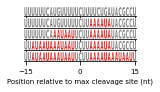

In [27]:
fig,axes = plt.subplots(5,1, figsize = (2,1), sharex = True, sharey = True)

xs = np.arange(-15,16,1)

for ax,ex in zip(axes,[example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]):
    
    ## plot sequence logo
    exseq = ex['sequence'][int(example_maxclv-15):int(example_maxclv+16)]
    encoding = cleavage.encode_sequence(exseq)
    seqmotif = pd.DataFrame(encoding, columns = ['A','C','G','U'], index = xs)

    logo = logomaker.Logo(seqmotif, ax = ax, width = 0.8, vpad = 0.05, color_scheme = {'A':'gray', 'U':'gray', 'G':'gray', 'C':'gray'})
    
    for i in ex['indices']:
        for j in np.arange(i,i+6,1):
            logo.style_single_glyph(int(j), exseq[int(j+15)].replace("T","U"), color = "#d62a28")

    ax.set_xticks(np.arange(-15,16,15))
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
axes[-1].set_xlabel("Position relative to max cleavage site (nt)")

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.low_entropy.{example_id.replace(":","_")}.example_sequence.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


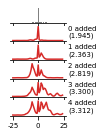

In [28]:
fig,axes = plt.subplots(6,1, figsize = (1,2), sharex = True, sharey = False)

for i,(ax,ex) in enumerate(zip(axes, [example_readvec, example_bin0, example_bin1, example_bin2, example_bin3, example_bin4])):
    
    if (i == 0):
        ax.bar(np.arange(0,50,1), ex, width = 1, color = 'gray')
    else:
        ax.plot(ex['cleavageVector'], color = '#d62a28')
        ax.text(x=1.05, y=1, s=f"{ex['count']} added\n({ex['cleavageEntropy']:.03f})", transform = ax.transAxes, ha = 'left', va = 'top')

    ax.set_xticks(np.arange(0,51,25))
    ax.set_xticklabels(np.arange(-25,26,25))
    
    ax.set_yticks([])
#     ax.set_ylim(0,example_bin_max*1.1)

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.low_entropy.{example_id.replace(":","_")}.example_cleavage.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Example 2

In [29]:
rs = 1976079352; example_id = "005807:XVI:835302:+"; example_iter = 4

example_gene    = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'gene'].iloc[0]
example_obsent  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'observed_entropy'].iloc[0]
example_maxclv  = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'ctr_cleavage'].iloc[0]
example_readvec = gold_tpdata.loc[gold_tpdata['label'] == example_id, 'readvec'].iloc[0]
print(f"Gene={example_gene}, observed_entropy={example_obsent}")

example_bin0 = lo_data.loc[(lo_data['testID'] == example_id) & (lo_data['iteration'] == 0) & (lo_data['count'] ==  0)].sample(1, random_state = rs).iloc[0]
example_bin1 = lo_data.loc[(lo_data['testID'] == example_id) & (lo_data['iteration'] == example_iter) & (lo_data['count'] == 1)].sample(1, random_state = rs).iloc[0]
example_bin2 = lo_data.loc[(lo_data['testID'] == example_id) & (lo_data['iteration'] == example_iter) & (lo_data['count'] == 2)].sample(1, random_state = rs).iloc[0]
example_bin3 = lo_data.loc[(lo_data['testID'] == example_id) & (lo_data['iteration'] == example_iter) & (lo_data['count'] == 3)].sample(1, random_state = rs).iloc[0]
example_bin4 = lo_data.loc[(lo_data['testID'] == example_id) & (lo_data['iteration'] == example_iter) & (lo_data['count'] == 4)].sample(1, random_state = rs).iloc[0]

example_bin_max = max([max(x['cleavageVector']) for x in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]])
print(f"Max normalized cleavage prediction: {example_bin_max}")

for e in [example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]:
    print(e.name, e['sequence'][int(example_maxclv-20):int(example_maxclv+20)], e['cleavageEntropy'], e['count'], sorted(e['indices'].tolist()))


Gene=YPR154W, observed_entropy=2.0049833289272705
Max normalized cleavage prediction: 0.31396201252937317
32642 AGTTCTACCTTTGGTGTTGTTATCCCTAGAATTTTTTTCT 2.4233882006771417 0 []
32653 AGTTCTACCTTTGAAAATATTATCCCTAGAATTTTTTTCT 3.034736886649679 1 [-7.0]
32654 AGTTCTACCTTTGAAAATATTAAATAATGAATTTTTTTCT 3.3476881194003565 2 [-7.0, 2.0]
32655 AGTTCTACCTTTGAAAATATTAAATAATTAATAATTTTCT 3.3557318124656743 3 [-7.0, 2.0, 8.0]
32656 AGTTCTTAATAAGAAAATATTAAATAATTAATAATTTTCT 3.6489010862442224 4 [-14.0, -7.0, 2.0, 8.0]


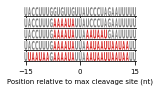

In [30]:
fig,axes = plt.subplots(5,1, figsize = (2,1), sharex = True, sharey = True)

xs = np.arange(-15,16,1)

for ax,ex in zip(axes,[example_bin0, example_bin1, example_bin2, example_bin3, example_bin4]):
    
    ## plot sequence logo
    exseq = ex['sequence'][int(example_maxclv-15):int(example_maxclv+16)]
    encoding = cleavage.encode_sequence(exseq)
    seqmotif = pd.DataFrame(encoding, columns = ['A','C','G','U'], index = xs)

    logo = logomaker.Logo(seqmotif, ax = ax, width = 0.8, vpad = 0.05, color_scheme = {'A':'gray', 'U':'gray', 'G':'gray', 'C':'gray'})
    
    for i in ex['indices']:
        for j in np.arange(i,i+6,1):
            logo.style_single_glyph(int(j), exseq[int(j+15)].replace("T","U"), color = "#d62a28")

    ax.set_xticks(np.arange(-15,16,15))
    ax.set_yticks([])
    
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
axes[-1].set_xlabel("Position relative to max cleavage site (nt)")

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.low_entropy.{example_id.replace(":","_")}.example_sequence.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


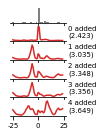

In [31]:
fig,axes = plt.subplots(6,1, figsize = (1,2), sharex = True, sharey = False)

for i,(ax,ex) in enumerate(zip(axes, [example_readvec, example_bin0, example_bin1, example_bin2, example_bin3, example_bin4])):
    
    if (i == 0):
        ax.bar(np.arange(0,50,1), ex, width = 1, color = 'gray')
    else:
        ax.plot(ex['cleavageVector'], color = '#d62a28')
        ax.text(x=1.05, y=1, s=f"{ex['count']} added\n({ex['cleavageEntropy']:.03f})", transform = ax.transAxes, ha = 'left', va = 'top')

    ax.set_xticks(np.arange(0,51,25))
    ax.set_xticklabels(np.arange(-25,26,25))
    
    ax.set_yticks([])
#     ax.set_ylim(0,example_bin_max*1.1)

    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'entropy_mechanisms.cleavage_site_addition.low_entropy.{example_id.replace(":","_")}.example_cleavage.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()
